In [1]:
!pip install torchsummary
import torch
import torchvision
from torchsummary import summary


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_values, std=std_values)
        ])

CIFAR10 = torchvision.datasets.CIFAR10(root =  'Datasets', download=True, transform=transform, train=True)



100%|██████████| 170498071/170498071 [00:02<00:00, 75249474.73it/s] 


Extracting Datasets/cifar-10-python.tar.gz to Datasets


In [5]:
dataloader = DataLoader(CIFAR10, batch_size= 256,shuffle= True)

In [6]:
CIFAR10.__getitem__(0)[0].shape

torch.Size([3, 32, 32])

In [31]:
import torchvision.models as models
import torch.nn as nn
# Importing VGG model
vgg = models.vgg16(pretrained=True).to(device)
vgg = nn.Sequential(*list(vgg.children())[:-1])

summary(vgg, (3, 32, 32))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [32]:
import torch.nn as nn
class model(nn.Module):
    def __init__(self, classifier, bit_length = 32):
        super(model, self).__init__()
        self.classifier = classifier

        # self.fc1 = nn.Sequential()
        # self.fc1.add_module('fc6_s1',nn.Linear(512, 1024)) #256*3*3
        # self.fc1.add_module('relu6_s1',nn.ReLU(inplace=True))
        # self.fc1.add_module('drop6_s1',nn.Dropout(p=0.5))

        # self.fc2 = nn.Sequential()
        # self.fc2.add_module('fc2',nn.Linear(1024, 512))
        # self.fc2.add_module('relu7',nn.ReLU(inplace=True))
        # self.fc2.add_module('drop7',nn.Dropout(p=0.5))

        # self.fc3 = nn.Sequential()
        # self.fc3.add_module('fc8',nn.Linear(512, hash_length))
        # self.fc3.add_module('tanh', nn.Tanh())
        self.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(512 * 7 * 7, 2048),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(2048, 2048),
                nn.ReLU(inplace=True),
                nn.Linear(2048, bit_length),
                # nn.Tanh()
            )
    def forward(self, x):
        x = self.classifier(x)
        x = torch.flatten(x, start_dim= 1, end_dim= 3)
        x = self.fc(x)
        # x = self.fc2(x)
        # x = self.fc3(x)
        return x


In [33]:
vgg_model = model(vgg, bit_length= 16)
vgg_model.to(device)

model(
  (classifier): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [34]:
image, labels = next(iter(dataloader))
image = image.to(device)
labels = labels.to(device)

output  = vgg_model(image)
output

tensor([[-0.0030,  0.2032,  0.1335,  ..., -0.0882,  0.0639, -0.0548],
        [-0.1830,  0.0665,  0.0611,  ..., -0.3321, -0.0393, -0.3994],
        [-0.1758,  0.2485, -0.0088,  ..., -0.1839, -0.3391, -0.0681],
        ...,
        [-0.0447,  0.1669,  0.1722,  ..., -0.0874,  0.0804,  0.0122],
        [ 0.0553, -0.0514,  0.1040,  ...,  0.0305, -0.1430,  0.0112],
        [ 0.0440,  0.0247,  0.2246,  ..., -0.0712, -0.2149, -0.0015]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [35]:
one_hot_labels = torch.nn.functional.one_hot(labels)
one_hot_labels.dtype

torch.int64

In [36]:
import torch.nn.functional as F
class MSE_loss(nn.Module):
    def __init__(self):
        super(MSE_loss, self).__init__()

    def forward(self, U,labels):
        L = F.one_hot(labels).to(torch.float64)
        S = torch.matmul(L, L.T)

        theta= 1/2 * torch.matmul(U, U.T)
        loss = torch.sum((S - theta) ** 2)
        return loss

In [37]:
def dpsh_loss(b, labels):
    """
    DPSH loss function for pairwise labels in supervised hashing.

    Args:
    b (torch.Tensor): The batch of binary codes, shape [batch_size, code_length], each element should be -1 or 1.
    S (torch.Tensor): The matrix of pairwise labels, shape [batch_size, batch_size],
                      S[i, j] = 1 if i and j are similar, 0 otherwise.

    Returns:
    torch.Tensor: The computed loss value.
    """
    # Ensure b is a float tensor for matrix multiplication
    L = F.one_hot(labels).to(torch.float64)
    S = torch.matmul(L, L.T)
    b = b.float()

    # Compute the matrix of inner products
    sim_matrix = 0.5 * torch.matmul(b, b.t())

    # Calculate the DPSH loss
    positive_term = S * sim_matrix
    log_term = torch.log(1 + torch.exp(sim_matrix))
    loss = -torch.sum(positive_term - log_term)

    return loss


In [38]:
class log_loss(nn.Module):
    def __init__(self):
        super(log_loss, self).__init__()

    def forward(self, U,labels):
        L = F.one_hot(labels).to(torch.float64)
        S = torch.matmul(L, L.T)


        theta= 1/2 * torch.matmul(U, U.T)

        J =  - (S * theta - torch.log(1 +   torch.exp(theta)))
        loss = 1/ 2 * torch.sum(J)
        return loss

In [39]:
import torch.optim as optim
from tqdm import tqdm


for name, param in vgg_model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = False

# parameters_to_optimize = [
#     vgg_model.fc1.parameters(),
#     vgg_model.fc2.parameters(),
#     vgg_model.fc3.parameters(),
# ]
# optimizer = optim.SGD(parameters_to_optimize, lr=0.001, momentum=0.9)
# optimizer = optim.SGD(vgg_model.fc.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(vgg_model.fc.parameters(), lr=0.001)
eta =  0.1
epochs = 150

loss_fn = MSE_loss()

loss_list = []
mse_loss_list = []

for epoch in range(epochs):  # loop over the dataset multiple times
    loop = tqdm(dataloader)
    total_loss = 0
    loss_ = 0
    for i, data in enumerate(loop):

        images, labels = data

        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        U = vgg_model(images)

        reg = torch.sum((torch.sgn(U) - U)**2)

        loss = loss_fn(U, labels)
        loss_ += loss
        loss = loss + (eta * reg)

        total_loss += loss

        loss.backward()
        optimizer.step()

        loop.set_postfix(epoch = epoch, loss=loss.item())

    total_loss = total_loss/ len(loop)
    loss_ = loss_/ len(loop)
    loss_list.append(total_loss.item())
    mse_loss_list.append(loss_.item())

    # if epoch % 5 == 0:
    print(f'Total loss:{total_loss.item()}, loss_ {loss_.item()}')
print('Finished Training')

100%|██████████| 196/196 [00:26<00:00,  7.54it/s, epoch=0, loss=755]


Total loss:111527712.60753094, loss_ 111527319.97558278


100%|██████████| 196/196 [00:26<00:00,  7.31it/s, epoch=1, loss=704]


Total loss:6385.418462179447, loss_ 6107.454737031032


100%|██████████| 196/196 [00:26<00:00,  7.54it/s, epoch=2, loss=648]


Total loss:6085.832931363095, loss_ 5808.824199170725


100%|██████████| 196/196 [00:26<00:00,  7.46it/s, epoch=3, loss=655]


Total loss:5870.720147494182, loss_ 5593.8656024848015


100%|██████████| 196/196 [00:26<00:00,  7.51it/s, epoch=4, loss=632]


Total loss:5676.750312815057, loss_ 5400.665347868232


100%|██████████| 196/196 [00:26<00:00,  7.43it/s, epoch=5, loss=601]


Total loss:5592.105241336354, loss_ 5317.512875254029


100%|██████████| 196/196 [00:26<00:00,  7.43it/s, epoch=6, loss=571]


Total loss:5494.047621628524, loss_ 5221.127139070874


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=7, loss=586]


Total loss:5432.212236597639, loss_ 5160.397471640601


100%|██████████| 196/196 [00:26<00:00,  7.47it/s, epoch=8, loss=615]


Total loss:5388.620513007271, loss_ 5117.900527979569


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=9, loss=589]


Total loss:5334.470823783743, loss_ 5064.94138467503


100%|██████████| 196/196 [00:26<00:00,  7.50it/s, epoch=10, loss=595]


Total loss:5290.208911692208, loss_ 5021.488938536778


100%|██████████| 196/196 [00:26<00:00,  7.28it/s, epoch=11, loss=563]


Total loss:5242.126831999727, loss_ 4974.267504683443


100%|██████████| 196/196 [00:27<00:00,  7.15it/s, epoch=12, loss=662]


Total loss:5190.773603960591, loss_ 4923.689202654749


100%|██████████| 196/196 [00:26<00:00,  7.41it/s, epoch=13, loss=596]


Total loss:5149.879433620141, loss_ 4883.171169911519


100%|██████████| 196/196 [00:26<00:00,  7.40it/s, epoch=14, loss=545]


Total loss:5099.575353379557, loss_ 4833.146342287661


100%|██████████| 196/196 [00:26<00:00,  7.53it/s, epoch=15, loss=562]


Total loss:5079.358817287448, loss_ 4813.018684048636


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=16, loss=608]


Total loss:5013.960063149989, loss_ 4748.702480310335


100%|██████████| 196/196 [00:26<00:00,  7.41it/s, epoch=17, loss=524]


Total loss:4992.427722881849, loss_ 4727.526721126777


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=18, loss=494]


Total loss:4965.304768501842, loss_ 4701.0295829752085


100%|██████████| 196/196 [00:26<00:00,  7.46it/s, epoch=19, loss=549]


Total loss:4911.982720673102, loss_ 4648.326322211315


100%|██████████| 196/196 [00:26<00:00,  7.44it/s, epoch=20, loss=554]


Total loss:4889.335363811818, loss_ 4626.321929966142


100%|██████████| 196/196 [00:26<00:00,  7.39it/s, epoch=21, loss=592]


Total loss:4865.947610378192, loss_ 4602.99962202376


100%|██████████| 196/196 [00:26<00:00,  7.53it/s, epoch=22, loss=526]


Total loss:4834.481229755719, loss_ 4572.008506281411


100%|██████████| 196/196 [00:26<00:00,  7.41it/s, epoch=23, loss=515]


Total loss:4796.308651318247, loss_ 4534.3094747479


100%|██████████| 196/196 [00:26<00:00,  7.48it/s, epoch=24, loss=559]


Total loss:4782.653126586363, loss_ 4520.739283081129


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=25, loss=553]


Total loss:4737.178834523361, loss_ 4476.0049055035115


100%|██████████| 196/196 [00:28<00:00,  6.98it/s, epoch=26, loss=580]


Total loss:4718.809100953868, loss_ 4457.988018274275


100%|██████████| 196/196 [00:26<00:00,  7.26it/s, epoch=27, loss=521]


Total loss:4706.653178381443, loss_ 4445.653891457352


100%|██████████| 196/196 [00:25<00:00,  7.57it/s, epoch=28, loss=486]


Total loss:4688.374886244357, loss_ 4427.863541062211


100%|██████████| 196/196 [00:25<00:00,  7.56it/s, epoch=29, loss=564]


Total loss:4667.597351438814, loss_ 4407.562075843286


100%|██████████| 196/196 [00:25<00:00,  7.56it/s, epoch=30, loss=557]


Total loss:4626.185172801826, loss_ 4366.566449146592


100%|██████████| 196/196 [00:26<00:00,  7.51it/s, epoch=31, loss=511]


Total loss:4611.69279569988, loss_ 4351.977112366152


100%|██████████| 196/196 [00:25<00:00,  7.54it/s, epoch=32, loss=539]


Total loss:4596.2864677969, loss_ 4336.872034531681


100%|██████████| 196/196 [00:26<00:00,  7.54it/s, epoch=33, loss=469]


Total loss:4576.085636531472, loss_ 4317.144409961497


100%|██████████| 196/196 [00:26<00:00,  7.54it/s, epoch=34, loss=488]


Total loss:4557.682945013159, loss_ 4298.807985807065


100%|██████████| 196/196 [00:26<00:00,  7.42it/s, epoch=35, loss=531]


Total loss:4525.050734774466, loss_ 4267.4639084110795


100%|██████████| 196/196 [00:26<00:00,  7.52it/s, epoch=36, loss=525]


Total loss:4499.3128834147865, loss_ 4242.194836479063


100%|██████████| 196/196 [00:25<00:00,  7.55it/s, epoch=37, loss=480]


Total loss:4472.0526605320165, loss_ 4215.861653968868


100%|██████████| 196/196 [00:26<00:00,  7.39it/s, epoch=38, loss=517]


Total loss:4458.096796886538, loss_ 4202.15830487062


100%|██████████| 196/196 [00:26<00:00,  7.53it/s, epoch=39, loss=435]


Total loss:4445.338818370799, loss_ 4190.005315348314


100%|██████████| 196/196 [00:26<00:00,  7.52it/s, epoch=40, loss=500]


Total loss:4437.034671758858, loss_ 4181.8394350467715


100%|██████████| 196/196 [00:25<00:00,  7.55it/s, epoch=41, loss=555]


Total loss:4392.159896953771, loss_ 4138.119828775009


100%|██████████| 196/196 [00:26<00:00,  7.50it/s, epoch=42, loss=553]


Total loss:4364.875739029034, loss_ 4111.326131226622


100%|██████████| 196/196 [00:26<00:00,  7.42it/s, epoch=43, loss=481]


Total loss:4335.193102027538, loss_ 4082.025088707861


100%|██████████| 196/196 [00:26<00:00,  7.53it/s, epoch=44, loss=427]


Total loss:4324.030999081605, loss_ 4071.2877505118827


100%|██████████| 196/196 [00:25<00:00,  7.54it/s, epoch=45, loss=480]


Total loss:4300.78968068137, loss_ 4048.275441117135


100%|██████████| 196/196 [00:26<00:00,  7.53it/s, epoch=46, loss=603]


Total loss:4285.733102452117, loss_ 4033.512548995597


100%|██████████| 196/196 [00:25<00:00,  7.54it/s, epoch=47, loss=390]


Total loss:4262.73808009398, loss_ 4011.145352354996


100%|██████████| 196/196 [00:26<00:00,  7.37it/s, epoch=48, loss=548]


Total loss:4231.70145978932, loss_ 3980.5683198481634


100%|██████████| 196/196 [00:25<00:00,  7.57it/s, epoch=49, loss=497]


Total loss:4234.036101884443, loss_ 3983.5239727430844


100%|██████████| 196/196 [00:25<00:00,  7.54it/s, epoch=50, loss=535]


Total loss:4176.708619721186, loss_ 3927.261962306846


100%|██████████| 196/196 [00:26<00:00,  7.43it/s, epoch=51, loss=416]


Total loss:4170.757817034373, loss_ 3921.7734247125327


100%|██████████| 196/196 [00:26<00:00,  7.47it/s, epoch=52, loss=505]


Total loss:4141.09014701902, loss_ 3892.960178687235


100%|██████████| 196/196 [00:25<00:00,  7.54it/s, epoch=53, loss=524]


Total loss:4115.875687992043, loss_ 3868.7272262025426


100%|██████████| 196/196 [00:26<00:00,  7.48it/s, epoch=54, loss=410]


Total loss:4087.402621320081, loss_ 3840.7422914235053


100%|██████████| 196/196 [00:26<00:00,  7.44it/s, epoch=55, loss=481]


Total loss:4056.8230459504193, loss_ 3811.050123707029


100%|██████████| 196/196 [00:26<00:00,  7.44it/s, epoch=56, loss=446]


Total loss:4042.3231203186415, loss_ 3797.2460533521753


100%|██████████| 196/196 [00:26<00:00,  7.48it/s, epoch=57, loss=457]


Total loss:4027.574570321194, loss_ 3782.8288881303183


100%|██████████| 196/196 [00:27<00:00,  7.17it/s, epoch=58, loss=560]


Total loss:4007.6558900774817, loss_ 3763.5589776545235


100%|██████████| 196/196 [00:26<00:00,  7.37it/s, epoch=59, loss=424]


Total loss:3987.7764260007953, loss_ 3744.7954914295497


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=60, loss=415]


Total loss:3937.924973502117, loss_ 3696.5135654086057


100%|██████████| 196/196 [00:26<00:00,  7.50it/s, epoch=61, loss=444]


Total loss:3938.5978568857436, loss_ 3697.358290900203


100%|██████████| 196/196 [00:26<00:00,  7.47it/s, epoch=62, loss=355]


Total loss:3916.067536748042, loss_ 3675.6375638074815


100%|██████████| 196/196 [00:26<00:00,  7.47it/s, epoch=63, loss=511]


Total loss:3876.562957174894, loss_ 3637.425298802678


100%|██████████| 196/196 [00:26<00:00,  7.51it/s, epoch=64, loss=403]


Total loss:3886.872962990428, loss_ 3647.830160880417


100%|██████████| 196/196 [00:26<00:00,  7.42it/s, epoch=65, loss=419]


Total loss:3846.955490293019, loss_ 3608.679750934624


100%|██████████| 196/196 [00:26<00:00,  7.39it/s, epoch=66, loss=476]


Total loss:3828.02814169822, loss_ 3590.5426579837076


100%|██████████| 196/196 [00:26<00:00,  7.44it/s, epoch=67, loss=474]


Total loss:3801.522572989385, loss_ 3564.9071889848337


100%|██████████| 196/196 [00:26<00:00,  7.50it/s, epoch=68, loss=488]


Total loss:3779.5098841746944, loss_ 3543.512444965397


100%|██████████| 196/196 [00:26<00:00,  7.32it/s, epoch=69, loss=450]


Total loss:3763.520283255387, loss_ 3527.8986674757434


100%|██████████| 196/196 [00:26<00:00,  7.51it/s, epoch=70, loss=478]


Total loss:3722.4615390169993, loss_ 3488.261919100979


100%|██████████| 196/196 [00:26<00:00,  7.48it/s, epoch=71, loss=498]


Total loss:3708.6093760218864, loss_ 3473.9333565868587


100%|██████████| 196/196 [00:26<00:00,  7.44it/s, epoch=72, loss=477]


Total loss:3686.361624925656, loss_ 3452.7535856146546


100%|██████████| 196/196 [00:26<00:00,  7.37it/s, epoch=73, loss=420]


Total loss:3666.324659265335, loss_ 3433.4891200897955


100%|██████████| 196/196 [00:26<00:00,  7.47it/s, epoch=74, loss=406]


Total loss:3643.851926276213, loss_ 3411.769147618026


100%|██████████| 196/196 [00:26<00:00,  7.50it/s, epoch=75, loss=409]


Total loss:3614.377381142292, loss_ 3382.861101376753


100%|██████████| 196/196 [00:26<00:00,  7.49it/s, epoch=76, loss=339]


Total loss:3597.2233675898233, loss_ 3366.1032439017677


100%|██████████| 196/196 [00:26<00:00,  7.46it/s, epoch=77, loss=427]


Total loss:3559.379788595373, loss_ 3329.099880006418


100%|██████████| 196/196 [00:26<00:00,  7.46it/s, epoch=78, loss=413]


Total loss:3548.6752140859544, loss_ 3319.0639954972626


100%|██████████| 196/196 [00:26<00:00,  7.33it/s, epoch=79, loss=424]


Total loss:3540.3421856854457, loss_ 3311.1184665751516


100%|██████████| 196/196 [00:26<00:00,  7.40it/s, epoch=80, loss=447]


Total loss:3542.192299722357, loss_ 3312.763677028925


100%|██████████| 196/196 [00:26<00:00,  7.44it/s, epoch=81, loss=315]


Total loss:3482.4617066393844, loss_ 3254.6178137050138


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=82, loss=427]


Total loss:3450.66113540925, loss_ 3223.893181225166


100%|██████████| 196/196 [00:26<00:00,  7.47it/s, epoch=83, loss=389]


Total loss:3429.6979706771403, loss_ 3203.5549207752947


100%|██████████| 196/196 [00:26<00:00,  7.50it/s, epoch=84, loss=394]


Total loss:3414.9029259071735, loss_ 3189.253490474584


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=85, loss=391]


Total loss:3390.407067447686, loss_ 3165.2599598757156


100%|██████████| 196/196 [00:26<00:00,  7.46it/s, epoch=86, loss=356]


Total loss:3364.0680677773694, loss_ 3139.0246031556517


100%|██████████| 196/196 [00:26<00:00,  7.44it/s, epoch=87, loss=299]


Total loss:3339.240183397203, loss_ 3115.307127791997


100%|██████████| 196/196 [00:26<00:00,  7.35it/s, epoch=88, loss=399]


Total loss:3360.532221047722, loss_ 3135.2077604537


100%|██████████| 196/196 [00:26<00:00,  7.37it/s, epoch=89, loss=375]


Total loss:3286.916924407642, loss_ 3064.1136096147757


100%|██████████| 196/196 [00:26<00:00,  7.36it/s, epoch=90, loss=367]


Total loss:3249.9335880072567, loss_ 3027.8140889953406


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=91, loss=362]


Total loss:3251.3569621790894, loss_ 3028.9442777579407


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=92, loss=422]


Total loss:3230.1576532217273, loss_ 3008.23746241057


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=93, loss=413]


Total loss:3209.462306350799, loss_ 2987.7061237775183


100%|██████████| 196/196 [00:26<00:00,  7.27it/s, epoch=94, loss=366]


Total loss:3169.245134663124, loss_ 2948.477737502691


100%|██████████| 196/196 [00:26<00:00,  7.39it/s, epoch=95, loss=436]


Total loss:3133.75775920801, loss_ 2913.1084732103473


100%|██████████| 196/196 [00:26<00:00,  7.48it/s, epoch=96, loss=381]


Total loss:3099.773123094469, loss_ 2880.45157140174


100%|██████████| 196/196 [00:26<00:00,  7.42it/s, epoch=97, loss=315]


Total loss:3100.8765319902113, loss_ 2881.2099222455745


100%|██████████| 196/196 [00:26<00:00,  7.50it/s, epoch=98, loss=307]


Total loss:3070.5584082619157, loss_ 2851.838543397177


100%|██████████| 196/196 [00:27<00:00,  7.26it/s, epoch=99, loss=300]


Total loss:3069.2422321414483, loss_ 2850.205681424971


100%|██████████| 196/196 [00:26<00:00,  7.51it/s, epoch=100, loss=423]


Total loss:3007.6434666901296, loss_ 2789.576904854977


100%|██████████| 196/196 [00:26<00:00,  7.40it/s, epoch=101, loss=315]


Total loss:3044.5609776982797, loss_ 2825.784893732589


100%|██████████| 196/196 [00:26<00:00,  7.38it/s, epoch=102, loss=292]


Total loss:2998.4256293807366, loss_ 2780.4894530028378


100%|██████████| 196/196 [00:26<00:00,  7.43it/s, epoch=103, loss=336]


Total loss:2994.166283280644, loss_ 2776.292550227239


100%|██████████| 196/196 [00:26<00:00,  7.33it/s, epoch=104, loss=413]


Total loss:2947.947755833068, loss_ 2731.0033776224946


100%|██████████| 196/196 [00:26<00:00,  7.41it/s, epoch=105, loss=386]


Total loss:2939.0331720566223, loss_ 2722.423707060908


100%|██████████| 196/196 [00:26<00:00,  7.42it/s, epoch=106, loss=386]


Total loss:2874.205452024229, loss_ 2658.464356695412


100%|██████████| 196/196 [00:26<00:00,  7.44it/s, epoch=107, loss=425]


Total loss:2867.3929137373043, loss_ 2651.917678362698


100%|██████████| 196/196 [00:26<00:00,  7.34it/s, epoch=108, loss=382]


Total loss:2848.3967428480087, loss_ 2632.806695595588


100%|██████████| 196/196 [00:27<00:00,  7.26it/s, epoch=109, loss=333]


Total loss:2871.95748850181, loss_ 2656.258679520361


100%|██████████| 196/196 [00:26<00:00,  7.46it/s, epoch=110, loss=290]


Total loss:2810.111771135885, loss_ 2595.32868420345


100%|██████████| 196/196 [00:26<00:00,  7.47it/s, epoch=111, loss=362]


Total loss:2787.4350193690093, loss_ 2572.9991435736833


100%|██████████| 196/196 [00:26<00:00,  7.47it/s, epoch=112, loss=433]


Total loss:2785.0392897431516, loss_ 2570.6792663224664


100%|██████████| 196/196 [00:26<00:00,  7.48it/s, epoch=113, loss=271]


Total loss:2775.020531028341, loss_ 2560.623028635203


100%|██████████| 196/196 [00:26<00:00,  7.50it/s, epoch=114, loss=420]


Total loss:2737.6020696312057, loss_ 2523.9457181524745


100%|██████████| 196/196 [00:26<00:00,  7.44it/s, epoch=115, loss=381]


Total loss:2748.1596534852797, loss_ 2534.1527989803244


100%|██████████| 196/196 [00:26<00:00,  7.47it/s, epoch=116, loss=331]


Total loss:2664.3342928712586, loss_ 2451.970487956745


100%|██████████| 196/196 [00:25<00:00,  7.62it/s, epoch=117, loss=303]


Total loss:2701.156212948418, loss_ 2487.9807810546213


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=118, loss=255]


Total loss:2636.9083321716953, loss_ 2425.2491896191054


100%|██████████| 196/196 [00:25<00:00,  7.61it/s, epoch=119, loss=330]


Total loss:2639.2249129756387, loss_ 2427.2100602961323


100%|██████████| 196/196 [00:26<00:00,  7.51it/s, epoch=120, loss=370]


Total loss:2618.047603589908, loss_ 2406.3664095180407


100%|██████████| 196/196 [00:26<00:00,  7.40it/s, epoch=121, loss=370]


Total loss:2597.897485347676, loss_ 2386.635635613429


100%|██████████| 196/196 [00:26<00:00,  7.39it/s, epoch=122, loss=295]


Total loss:2593.466977640715, loss_ 2382.2495785106526


100%|██████████| 196/196 [00:25<00:00,  7.61it/s, epoch=123, loss=318]


Total loss:2566.595565873362, loss_ 2355.8978383196636


100%|██████████| 196/196 [00:25<00:00,  7.58it/s, epoch=124, loss=243]


Total loss:2555.462624011641, loss_ 2345.1270758443143


100%|██████████| 196/196 [00:25<00:00,  7.61it/s, epoch=125, loss=241]


Total loss:2541.4287686850525, loss_ 2331.2794594099514


100%|██████████| 196/196 [00:25<00:00,  7.58it/s, epoch=126, loss=306]


Total loss:2488.831028060675, loss_ 2279.651950639759


100%|██████████| 196/196 [00:25<00:00,  7.57it/s, epoch=127, loss=274]


Total loss:2508.7019544693067, loss_ 2298.838336513885


100%|██████████| 196/196 [00:26<00:00,  7.36it/s, epoch=128, loss=270]


Total loss:2504.063666975218, loss_ 2294.347436232433


100%|██████████| 196/196 [00:25<00:00,  7.59it/s, epoch=129, loss=283]


Total loss:2496.136274795333, loss_ 2286.3415723043518


100%|██████████| 196/196 [00:25<00:00,  7.62it/s, epoch=130, loss=356]


Total loss:2450.118479453744, loss_ 2241.2109466255492


100%|██████████| 196/196 [00:25<00:00,  7.61it/s, epoch=131, loss=386]


Total loss:2448.8197646224617, loss_ 2239.7150483020346


100%|██████████| 196/196 [00:25<00:00,  7.54it/s, epoch=132, loss=315]


Total loss:2428.491374115718, loss_ 2220.27637637651


100%|██████████| 196/196 [00:25<00:00,  7.58it/s, epoch=133, loss=304]


Total loss:2461.0046914543395, loss_ 2250.976331359997


100%|██████████| 196/196 [00:26<00:00,  7.45it/s, epoch=134, loss=312]


Total loss:2397.7854189924064, loss_ 2189.8748875786087


100%|██████████| 196/196 [00:26<00:00,  7.46it/s, epoch=135, loss=254]


Total loss:2363.1736990913014, loss_ 2156.017368359852


100%|██████████| 196/196 [00:26<00:00,  7.39it/s, epoch=136, loss=361]


Total loss:2342.8248973042946, loss_ 2135.947749824362


100%|██████████| 196/196 [00:26<00:00,  7.36it/s, epoch=137, loss=270]


Total loss:2361.562581197515, loss_ 2154.3299331265375


100%|██████████| 196/196 [00:27<00:00,  7.17it/s, epoch=138, loss=330]


Total loss:2360.47859196552, loss_ 2153.397779199893


100%|██████████| 196/196 [00:26<00:00,  7.36it/s, epoch=139, loss=319]


Total loss:2339.9869285322625, loss_ 2132.8841285133285


100%|██████████| 196/196 [00:27<00:00,  7.18it/s, epoch=140, loss=292]


Total loss:2316.1539764518934, loss_ 2109.4569938930013


100%|██████████| 196/196 [00:26<00:00,  7.35it/s, epoch=141, loss=349]


Total loss:2317.307941163019, loss_ 2110.6748091821237


100%|██████████| 196/196 [00:26<00:00,  7.39it/s, epoch=142, loss=285]


Total loss:2334.939135281411, loss_ 2127.9399482011836


100%|██████████| 196/196 [00:26<00:00,  7.36it/s, epoch=143, loss=299]


Total loss:2258.1043020915126, loss_ 2052.557990460018


100%|██████████| 196/196 [00:26<00:00,  7.38it/s, epoch=144, loss=218]


Total loss:2289.6874743668445, loss_ 2083.731205355638


100%|██████████| 196/196 [00:26<00:00,  7.29it/s, epoch=145, loss=306]


Total loss:2287.1659616140787, loss_ 2080.876282767992


100%|██████████| 196/196 [00:26<00:00,  7.40it/s, epoch=146, loss=248]


Total loss:2277.3353652679693, loss_ 2071.144934607332


100%|██████████| 196/196 [00:26<00:00,  7.40it/s, epoch=147, loss=260]


Total loss:2235.9464100959044, loss_ 2030.5480757484327


100%|██████████| 196/196 [00:27<00:00,  7.22it/s, epoch=148, loss=357]


Total loss:2212.398634284665, loss_ 2007.3683696053988


100%|██████████| 196/196 [00:26<00:00,  7.31it/s, epoch=149, loss=257]

Total loss:2216.5880468730543, loss_ 2011.3560713565605
Finished Training


In [41]:
torch.save(vgg_model.state_dict(), 'vgg16.pth')

In [42]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(vgg_model.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16.pth')

Mounted at /content/drive


In [43]:
#loading
loaded_state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/vgg16.pth')

# Load state dictionary into model
vgg_model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

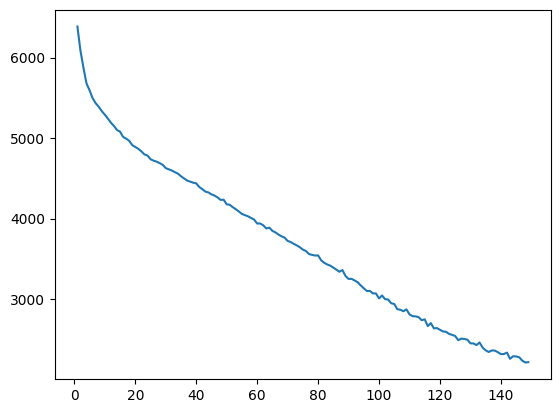

In [44]:
import matplotlib.pyplot as plt

epoch = range(1,len(loss_list))
plt.plot(epoch, loss_list[1:])
plt.show()

In [ ]:
# epoch = range(0,40)
# plt.plot(epoch, mse_loss_list)
# plt.show()

In [45]:
import numpy as np

def CalcHammingDist(B1, B2):
    q = B2.shape[1]
    distH = 0.5 * (q - np.dot(B1, B2.transpose()))
    return distH

def CalcMap(qB, rB, queryL, retrievalL):
    num_query = queryL.shape[0]
    map = 0
    for iter in range(num_query):
        gnd = (np.dot(queryL[iter, :], retrievalL.transpose()) > 0).astype(np.int64)
        tsum = np.sum(gnd)
        if tsum == 0:
            continue
        hamm = CalcHammingDist(qB[iter, :], rB)
        ind = np.argsort(hamm)
        gnd = gnd[ind]
        count = np.linspace(1, tsum, tsum)
        tindex = np.asarray(np.where(gnd == 1)) + 1.0
        map_ = np.mean(count / (tindex))
        map = map + map_
    map = map / num_query
    return map

def CalcTopMap(qB, rB, queryL, retrievalL, topk):
    num_query = queryL.shape[0]
    topkmap = 0
    for iter in range(num_query):
        gnd = (np.dot(queryL[iter, :], retrievalL.transpose()) > 0).astype(np.int64)
        hamm = CalcHammingDist(qB[iter, :], rB)
        ind = np.argsort(hamm)
        gnd = gnd[ind]
        tgnd = gnd[0:topk]
        tsum = np.sum(tgnd)
        if tsum == 0:
            continue
        count = np.linspace(1, tsum, tsum)
        tindex = np.asarray(np.where(tgnd == 1)) + 1.0
        topkmap_ = np.mean(count / (tindex))
        topkmap = topkmap + topkmap_
    topkmap = topkmap / num_query
    return topkmap


In [46]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_values, std=std_values)
        ])

CIFAR10_test = torchvision.datasets.CIFAR10(root =  'Datasets', download=True, transform=transform, train = False)

testloader = DataLoader(CIFAR10_test, batch_size= 256,shuffle= True)

Files already downloaded and verified


In [47]:
list = []
labels_list = []
for images, labels in testloader:

    images = images.to(device)
    labels = labels.to(device)

    vgg_model.eval()
    U  = vgg_model(images)
    B = torch.sgn(U)
    B  = B.detach().cpu().numpy().astype(np.int64)
    list.append(B)

    labels = F.one_hot(labels).detach().cpu().numpy()
    labels_list.append(labels)

qB = np.concatenate(list, axis = 0)
test_labels = np.concatenate(labels_list, axis = 0)

In [48]:
list = []
labels_list = []
for images, labels in dataloader:

    images = images.to(device)
    labels = labels.to(device)

    vgg_model.eval()
    U  = vgg_model(images)
    B = torch.sgn(U)
    B  = B.detach().cpu().numpy().astype(np.int64)
    list.append(B)

    labels = F.one_hot(labels).detach().cpu().numpy()
    labels_list.append(labels)

rB = np.concatenate(list, axis = 0)
train_labels = np.concatenate(labels_list)

In [49]:
qB.shape

(10000, 16)

In [50]:
CalcMap(qB, rB, test_labels, train_labels)

0.6752903300211599

In [51]:
topk = 15
CalcTopMap(qB, rB, test_labels, train_labels, topk)

0.6692254578033382